# Setup & Data preprocessing

In [ ]:
# Dataset sourced from https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery/data
# Set up using Anaconda, utilising conda for package management

In [1]:
import os
import random
import shutil
import cv2
import pandas as pd
from tensorflow import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras import ops
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

print(keras.__version__)

3.6.0


## Data

In [ ]:
# each img name is made up of:
#    a binary label (representing whether the img contains a ship or not), 
#    id of the planetscope scene the img is sourced from
#    and long n latitude coordinates of the centre img point
# separated by __ (double underscore)
images_df = pd.DataFrame(columns = ['path', 'ship_label', 'scene_id', 'longitude', 'latitude'])
images_path = "/Users/mj/Desktop/proj/ships/shipsnet/shipsnet"  
#                ^ change this address to the location the dataset was downloaded too; i'm including the original address here to show the nestled shipnet folders
#                  i've not included the dataset in the repository seeing as it's 4000 thousand files, and the set up required is minimal

for dirname, _, files in os.walk(images_path):
    for file in files:
         # checks that the filename has exactly two underscores
        if file.count("__") == 2: 
            try:
                path = os.path.join(dirname, file)
                filename_split_list = file.split("__")
                ship_label = int(filename_split_list[0])
                scene_id = filename_split_list[1]
                    
                coordinates_list = filename_split_list[2].split("_")
                coordinates_long = float(coordinates_list[0])
                coordinates_lat = float(coordinates_list[1].rstrip(".png"))

                # using .loc and setting the values of that row of the df to those listed here
                images_df.loc[len(images_df)] = [path, ship_label, scene_id, coordinates_long, coordinates_lat]
            except Exception as e:
                print(f"Error processing file {file}: {e}")
        else:
            print(f"Skipping file {file}, invalid format")

for dirname, _, files in os.walk(images_path):
    print(f"Files in directory: {len(files)}")

print(images_df.shape)
images_df.head()

Files in directory: 4000
(4000, 5)


,path,ship_label,scene_id,longitude,latitude
0,/Users/mj/Desktop/proj/ships/shipsnet/shipsnet...,0,20180708_180908_0f47,-118.148807,33.730089
1,/Users/mj/Desktop/proj/ships/shipsnet/shipsnet...,1,20180711_180503_1027,-118.227597,33.721431
2,/Users/mj/Desktop/proj/ships/shipsnet/shipsnet...,0,20170605_180825_1032,-122.389609,37.740861
3,/Users/mj/Desktop/proj/ships/shipsnet/shipsnet...,0,20170730_181513_0e20,-122.342797,37.751641
4,/Users/mj/Desktop/proj/ships/shipsnet/shipsnet...,0,20170702_180943_103c,-122.292418,37.738695


### Data distribution

/var/folders/jx/mpd8cys52sg360131s8fhx3r0000gn/T/ipykernel_17516/920730544.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=images_df, x='ship_label', hue=None, palette='Set3')


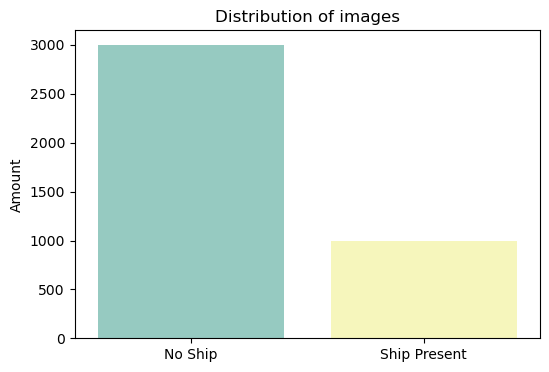

In [601]:
ship_label_count = images_df['ship_label'].value_counts()

plt.figure(figsize=(6, 4))
sns.countplot(data=images_df, x='ship_label', hue=None, palette='Set3')
plt.title('Distribution of images')
plt.xlabel('') # the bars are labelled so it seems excessive
plt.ylabel('Amount')
plt.xticks([0, 1], ['No Ship', 'Ship Present'])
plt.show()

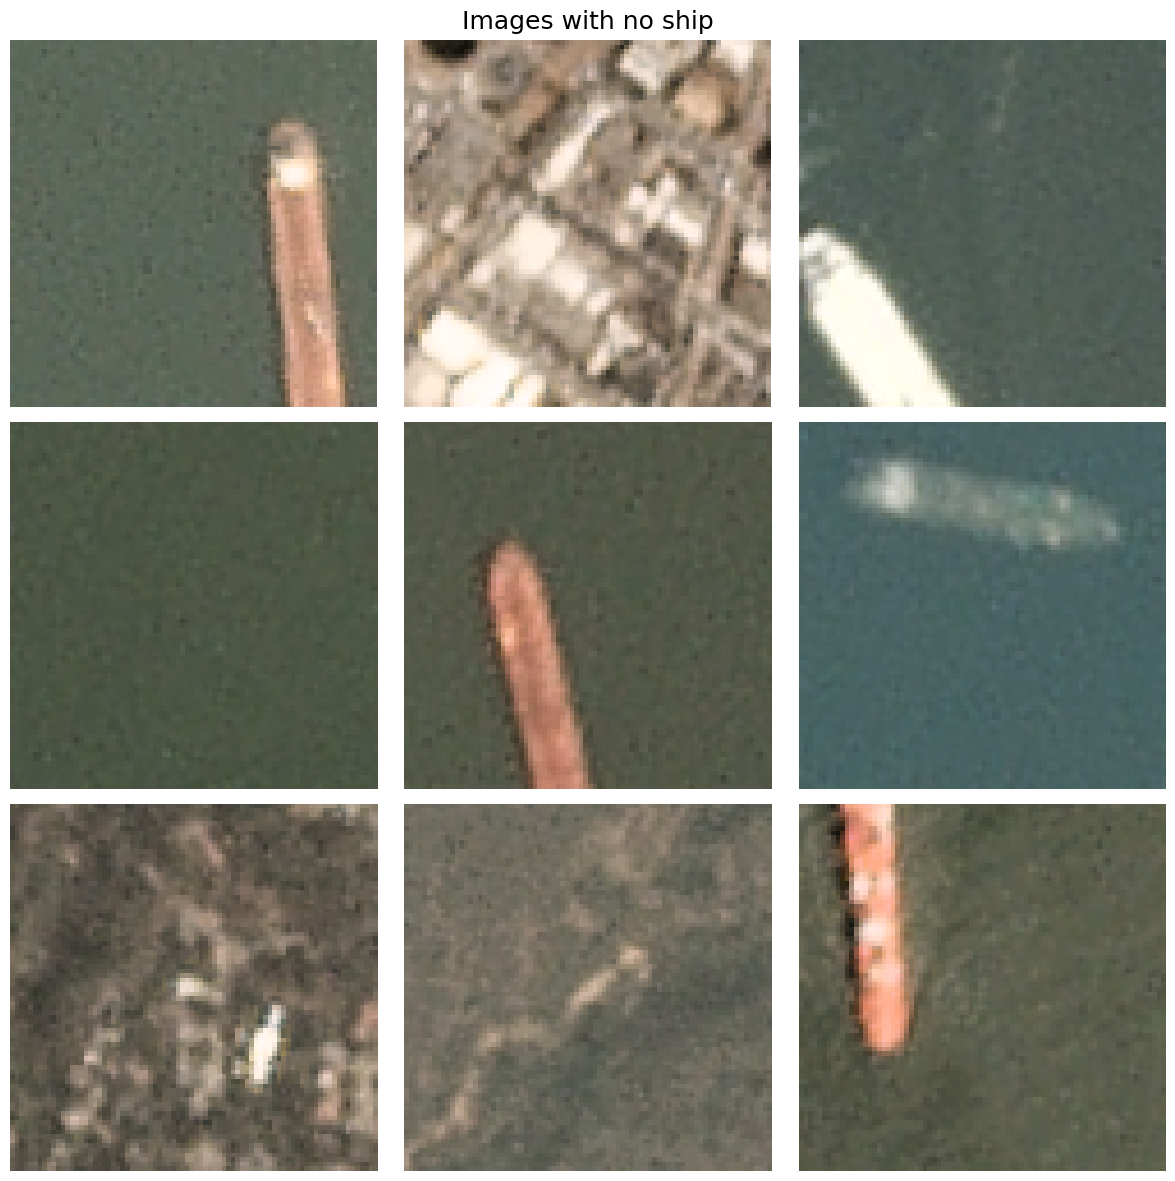

In [726]:
no_ship_list = list(np.where(images_df["ship_label"] == 0))
no_ship_list = no_ship_list[0].tolist()

figure, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for x in range(9) :
        image = mpimg.imread(images_df.iloc[int(no_ship_list[x])]['path'])
        axes[x].imshow(image)
        axes[x].axis('off')

plt.suptitle("Images with no ship", fontsize=18)
plt.tight_layout()
plt.show()

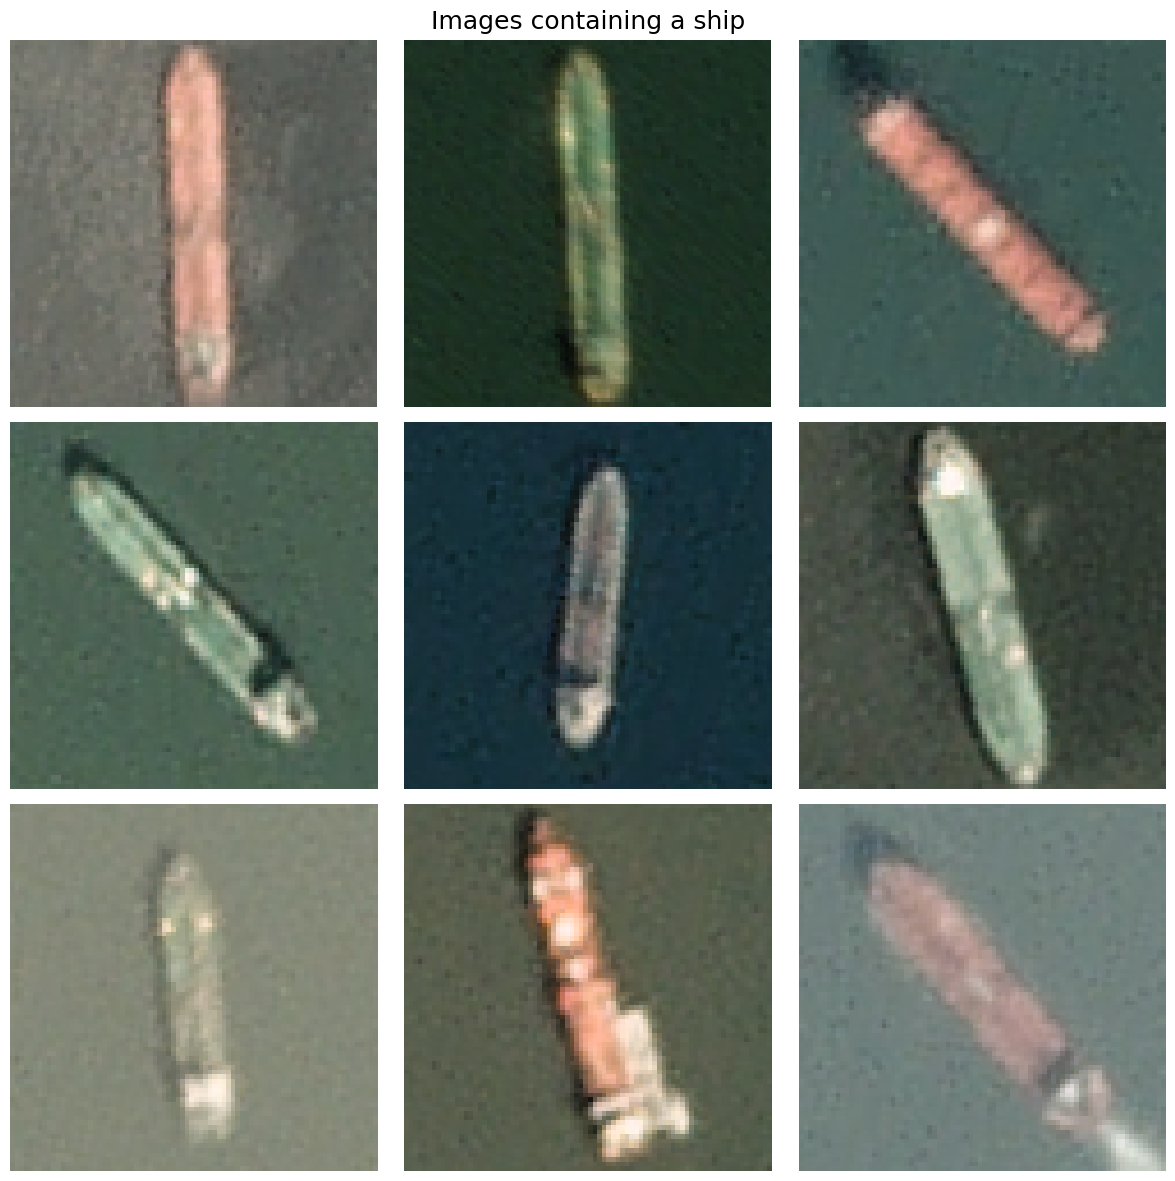

In [732]:
yes_ship_list = list(np.where(images_df["ship_label"] == 1))
yes_ship_list = yes_ship_list[0].tolist()

figure, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for x in range(9) :
        image = mpimg.imread(images_df.iloc[int(yes_ship_list[x])]['path'])
        axes[x].imshow(image)
        axes[x].axis('off')

plt.suptitle("Images containing a ship", fontsize=18)
plt.tight_layout()
plt.show()

### Data preprocessing

In [606]:
# resizes images to 80x80 (just in case), turns them greyscale (for easier processing), normalises pixel value
def preprocess(df, image_path='path', size=(80, 80)):
    images_npa = []
    for path in df[image_path]:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, size)
        image = image / 255.0
        images_npa.append(image)
    return np.array(images_npa)

In [604]:
train_df, test_df = train_test_split(images_df, test_size=0.2, random_state = 42)

In [610]:
# these are numpy arrays
x_train = preprocess(train)
x_test = preprocess(test)

#  & these are dfs
y_train = train
y_train = y_train.drop(['path', 'scene_id', 'longitude', 'latitude'], axis=1) # leaves only index and label
y_test = test
y_test = y_test.drop(['path', 'scene_id', 'longitude', 'latitude'], axis=1)

In [612]:
print(y_train.shape)
y_train.head()

(3200, 1)


,ship_label
3994,0
423,0
2991,1
1221,1
506,0


In [613]:
print(y_test.shape)
y_test.head()

(800, 1)


,ship_label
555,0
3491,0
527,0
3925,1
2989,1


In [615]:
###############################################################################
###############################################################################
###############################################################################
###############################################################################

In [619]:
y_train_en = to_categorical(y_train)
y_train_en = np.asarray(y_train_en).astype('float32')
print(y_train_en.shape)

y_test_en = to_categorical(y_test)
y_test_en = np.asarray(y_test_en).astype('float32')
print(y_test_en.shape)

(3200, 2)
(800, 2)


# Defining & training the model

In [750]:
model = keras.Sequential(
    [
        # input
        layers.InputLayer(shape=(80, 80, 1)),
        # layer 1
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # layer 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Dropout(0.1),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # layer 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        # combining features into outcome
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ]
)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary

<bound method Model.summary of <Sequential name=sequential_40, built=True>>

In [748]:
learning_rate_callback = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(x_train, y_train, batch_size = 10, epochs = 10, callbacks=learning_rate_callback)

Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.9997 - loss: 4.5713e-04 - learning_rate: 9.0000e-05
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 1.0000 - loss: 3.9562e-04 - learning_rate: 9.0000e-05
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.9992 - loss: 7.9246e-04 - learning_rate: 9.0000e-05
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 1.5676e-04
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
320/320 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 1.0000 - loss: 1.5704e-04 - learning_rate: 9.0000e-05
Epoch 5/10
 52/320 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 1.0000 - loss: 3.6389e-06

# Model evaluation

In [755]:
print(history.history.keys())
print()
print(history.history['loss']) # loss value for each epoch
print()
print(history.history['accuracy']) # accuracy for each epoch

dict_keys(['accuracy', 'loss', 'learning_rate'])

[0.41623276472091675, 0.1362941861152649, 0.1024458035826683, 0.07500635832548141, 0.06274288147687912, 0.055956654250621796, 0.059609562158584595, 0.030566329136490822, 0.03488661348819733, 0.05284997075796127]

[0.8959375023841858, 0.9606249928474426, 0.9746875166893005, 0.9821875095367432, 0.9846875071525574, 0.9903125166893005, 0.9887499809265137, 0.9915624856948853, 0.9912499785423279, 0.9943749904632568]


In [805]:
test_loss, test_accuracy = model.evaluate(x_test, y_test) # accuracy and loss on the test data

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9580 - loss: 0.2720


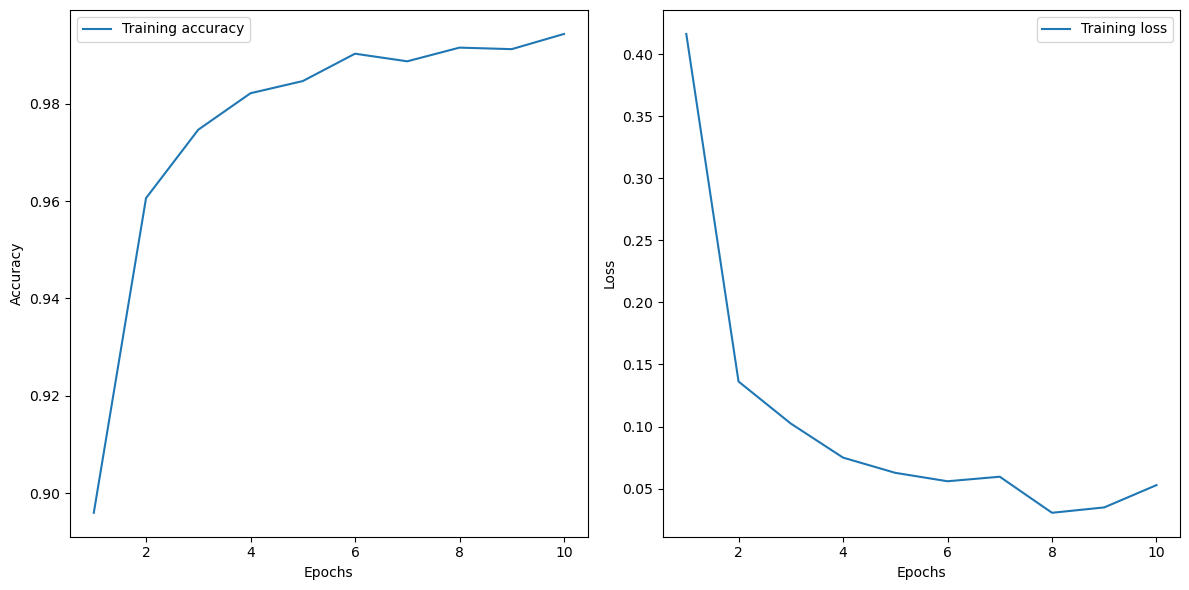

In [797]:
# retrieving accuracy n loss
accuracy = history.history.get('accuracy', [])
loss = history.history.get('loss', [])
    
epoch_range = range(1, len(accuracy) + 1)
plt.figure(figsize=(12, 6))

# accuracy graph
plt.subplot(1, 2, 1)  # using subplot to display the graphs next to each other for easier comparison
plt.plot(epoch_range, accuracy, label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# loss graph
plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
    
plt.tight_layout()
plt.show()

### Confusion matrix

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


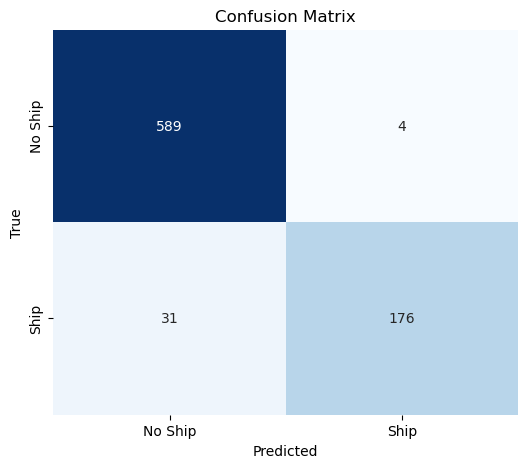

[[589   4]
 [ 31 176]]


In [815]:
predictions = model.predict(x_test)
predictions = (predictions > 0.5).astype(int)

conmat = confusion_matrix(y_test, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(conmat, annot=True, fmt='d', cmap='Blues', xticklabels=['No Ship', 'Ship'], yticklabels=['No Ship', 'Ship'], cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# evil graph
plt.show()
print(conmat)

# Hyperparameters tuning

In [817]:
# lowering batch size
history = model.fit(x_train, y_train, batch_size = 5, epochs = 10, callbacks=learning_rate_callback)

Epoch 1/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.9943 - loss: 0.0255 - learning_rate: 3.0000e-04
Epoch 2/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9977 - loss: 0.0050 - learning_rate: 3.0000e-04
Epoch 3/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.9998 - loss: 0.0020 - learning_rate: 3.0000e-04
Epoch 4/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.9990 - loss: 0.0073 - learning_rate: 3.0000e-04
Epoch 5/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.9993 - loss: 0.0023 - learning_rate: 3.0000e-04
Epoch 6/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.9975 - loss: 0.0086 - learning_rate: 3.0000e-04
Epoch 7/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.9991 - loss: 0.0024 - learning_rate: 3.0000e-04
Epoch 8/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - accuracy: 1.0000 - loss: 4.4876e-05 - learning_rate: 3.0000e-04
Epoch 9/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


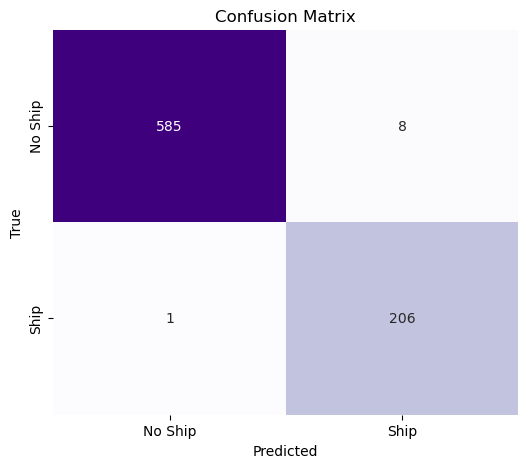

[[585   8]
 [  1 206]]


In [843]:
predictions = model.predict(x_test)
predictions = (predictions > 0.5).astype(int)

conmat = confusion_matrix(y_test, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(conmat, annot=True, fmt='d', cmap='Purples', xticklabels=['No Ship', 'Ship'], yticklabels=['No Ship', 'Ship'], cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()
print(conmat)
# lower batch size appears to have made the model better at id-ing ships
# (no-ship true positive is the same)

## EarlyStopping & lower learning rate

In [845]:
# using earlystopping to stop the model from over training
# and using adam, an adaptive optimizer, with a low learning rate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
optimizer = Adam(learning_rate=0.0005)
# validation data was not previously defined - using validation split instead for now
model.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=10, callbacks=[early_stopping])

Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.9994 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 1.2370e-06
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.9998 - loss: 2.0912e-04 - val_accuracy: 1.0000 - val_loss: 5.0966e-07
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 1.0000 - loss: 1.8889e-06 - val_accuracy: 1.0000 - val_loss: 4.7062e-07
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 1.0000 - loss: 1.8022e-06 - val_accuracy: 1.0000 - val_loss: 4.9428e-06
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 1.0000 - loss: 5.9749e-05 - val_accuracy: 1.0000 - val_loss: 1.4718e-06
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.9982 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 4.5775e-07
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 1.0000 - loss: 2.5089e-05 - val_accuracy: 1.0000 - val_loss: 1.0322e-06
Epoch 8/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 15

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


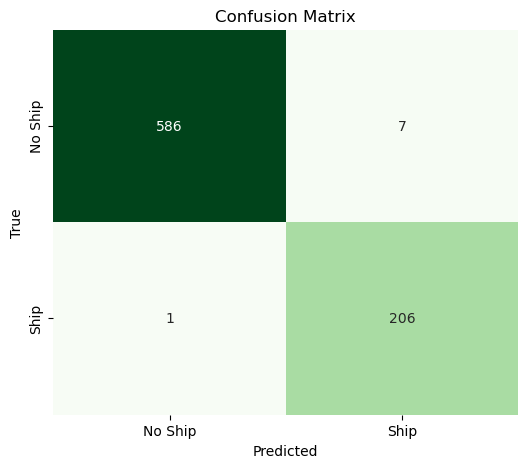

[[586   7]
 [  1 206]]


In [847]:
predictions = model.predict(x_test)
predictions = (predictions > 0.5).astype(int)

conmat = confusion_matrix(y_test, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(conmat, annot=True, fmt='d', cmap='Greens', xticklabels=['No Ship', 'Ship'], yticklabels=['No Ship', 'Ship'], cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()
print(conmat)
# minor difference from just lowering the batch size, but an improvement upon the base model nontheless

In [859]:
recall = recall_score(y_test, predictions)
print(f"Recall: {recall:.2f}")

Recall: 1.00


## Preprocessing

In [865]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation

model_p = keras.Sequential(
    [
        # input (has to go first)
        layers.InputLayer(shape=(80, 80, 1)),
        # data augmentation
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2), # rotates the image by 20%
        layers.RandomZoom(0.2), # randomly zooms either in or our by 20%
        layers.RandomTranslation(0.1, 0.1), # shifts horizontally and vertically
        # layer 1
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # layer 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Dropout(0.1),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # layer 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Dropout(0.2),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        # combining features into outcome
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ]
)
model_p.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model_p.summary

<bound method Model.summary of <Sequential name=sequential_42, built=True>>

In [871]:
# with lower batch size as well as earlystop
# longer processing time but theoretically should improve upon all of the previous iterations
# 10 epochs (instead of the 20 i was originally trying to do) as my laptop seemed to be stopping after 10 without explanation (no sign of earlystop)
history = model_p.fit(x_train, y_train, batch_size = 5, epochs = 10, callbacks=[early_stopping])

Epoch 1/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.9050 - loss: 0.2993
Epoch 2/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.9138 - loss: 0.2713
Epoch 3/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.8961 - loss: 0.2857
Epoch 4/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.9136 - loss: 0.2596
Epoch 5/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.9232 - loss: 0.2141
Epoch 6/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.9236 - loss: 0.2181
Epoch 7/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9374 - loss: 0.1950
Epoch 8/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.9312 - loss: 0.1941
Epoch 9/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.9310 - loss: 0.2123
Epoch 10/10
640/640 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.9287 - loss: 0.2250


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


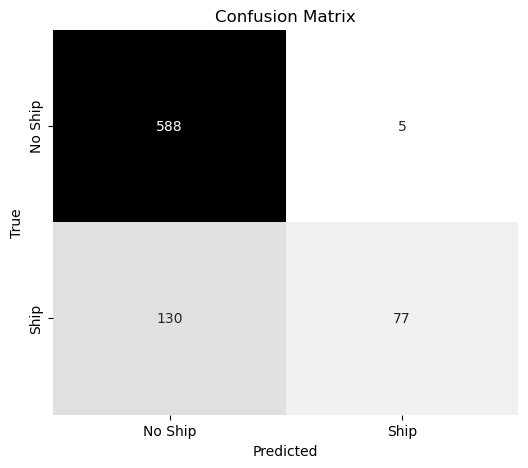

[[588   5]
 [130  77]]


In [873]:
predictions = model_p.predict(x_test)
predictions = (predictions > 0.5).astype(int)

conmat = confusion_matrix(y_test, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(conmat, annot=True, fmt='d', cmap='Greys', xticklabels=['No Ship', 'Ship'], yticklabels=['No Ship', 'Ship'], cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.show()
print(conmat)

In [879]:
print("Loss: " , model_p.evaluate(x_test,y_test)[0])
print("Accuracy: " , model_p.evaluate(x_test,y_test)[1]*100 , "%")

recall = recall_score(y_test, predictions)
print(f"Recall: {recall:.2f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8324 - loss: 0.5762
Loss:  0.5590391159057617
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8324 - loss: 0.5762
Accuracy:  83.1250011920929 %
Recall: 0.37


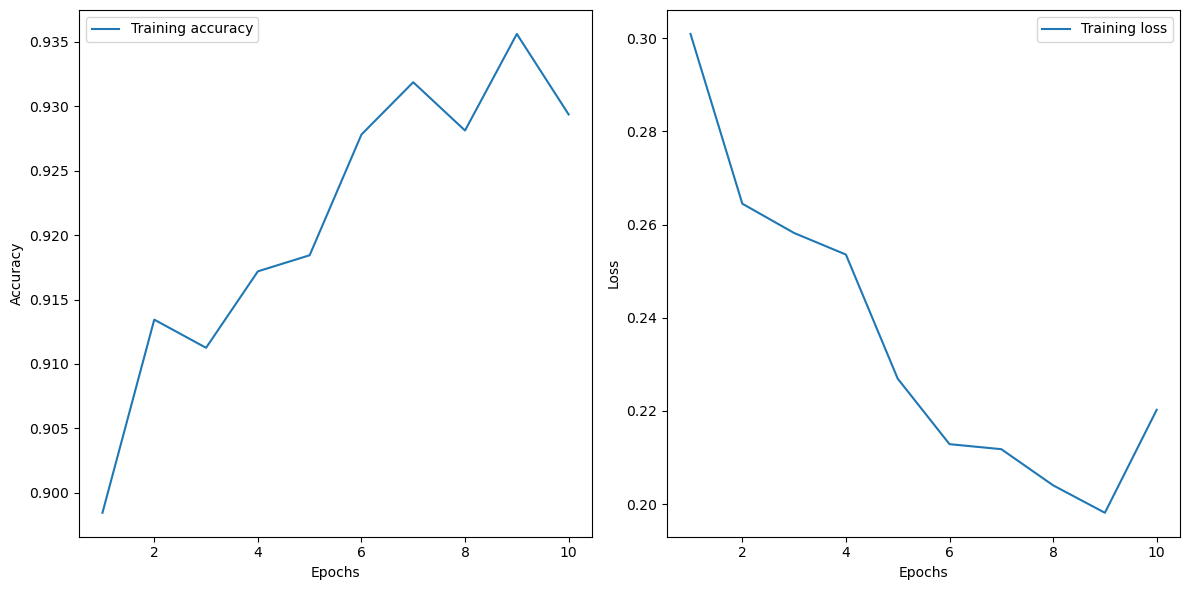

In [877]:
# retrieving accuracy n loss
accuracy = history.history.get('accuracy', [])
loss = history.history.get('loss', [])
    
epoch_range = range(1, len(accuracy) + 1)
plt.figure(figsize=(12, 6))

# accuracy graph
plt.subplot(1, 2, 1)  # using subplot to display the graphs next to each other for easier comparison
plt.plot(epoch_range, accuracy, label='Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# loss graph
plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
    
plt.tight_layout()
plt.show()